In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

In [2]:
# Prices to scan
prices = ['1e-06', '0p08', '0p16', '0p25', '0p33', '0p41', '0p49', '0p58', '0p66', '0p74', '0p82', '0p91', '0p99', '1p07', '1p15', '1p24', '1p32', '1p4', '1p48', '1p57', '1p65']

# Colors
colors = {'price_taker': '#DE3163', 'price_maker': '#00008B'}
color_shades = {'price_taker': ['#f091ac', '#e54573', '#c0063b'], 'price_maker': ['#9c9cea', '#5757d3', '#04049d']}

# Font
font_path = 'Helvetica.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Helvetica'

In [3]:
def get_btes_investment(component_results):
    """
    Get capital expenditure for BTES, i.e. sum of discharge, charge and energy store investment
    """
    btes_investment = 0
    for comp in [('Link','BTES_charger'), ('Link','BTES_discharger'), ('Store','granite')]:
        btes_investment += component_results[component_results.index == comp]['Capital Expenditure [$]'].values[0]
        btes_investment += component_results[component_results.index == comp]['Operational Expenditure [$]'].values[0]
    return btes_investment

In [4]:
def read_output_file(filename):
    """
    Read file results
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)

        # Get cost from file name
        btes_cost = (filename.split('_')[-1].split('.')[0])

        # Get results from file
        time_inputs = data['time inputs']
        case_data = data['case results']
        comp_results = data['component results']
        time_results = data['time results']

        return time_inputs, case_data, comp_results, time_results, btes_cost
    

In [5]:
def plot_bars_maker_taker(case, x,y, xlabel, ylabel, title=None, y2=None):
    """
    Plot bar chart for price maker and price taker
    """
    from matplotlib.ticker import ScalarFormatter

    plt.figure()
    # x axis in percent
    x = [int(x*100) for x in x]
    for run,cost in y.items():
        plt.plot(x, cost, 'o', color=colors[run], label=run)
        plt.plot(x, cost, color=colors[run], label=run)
        if y2 is not None:
            plt.plot(x, y2[run], 'o', color=color_shades[run][0], label=f"{run} residence")
            plt.plot(x, y2[run], color=color_shades[run][0], label=f"{run} residence")
            plt.yscale('log')
            plt.ylim(0.1, 1000)
            plt.yticks([0.1, 1, 10, 100, 1000], labels=['0.1', '1', '10', '100', '1000'], fontsize=15)
        else:
            plt.ylim(bottom=0)
            plt.yticks(fontsize=15)

    # Add horizontal line at 1 if Value added is plotted
    if 'Value added' in ylabel:
        plt.axhline(y=1, color='black', linestyle='dashed')

    if 'BTES' in xlabel: 
        xlabel = xlabel.replace('BTES','underground thermal storage')
    plt.xlabel(xlabel, fontsize=18)
    plt.xlim(0, 165)
    plt.ylabel(ylabel, fontsize=18)
    # Axis tick labels size
    # Add % to x-axis tick labels
    plt.xticks(ticks=[0, 20, 40, 60, 80, 100, 120, 140, 160], labels=[f"{i}%" for i in [0, 20, 40, 60, 80, 100, 120, 140, 160]], fontsize=15)
    plt.savefig('figures/btes_{0}_{1}.pdf'.format(title.replace(' ','_').replace(',','').lower(), case), bbox_inches='tight', dpi=500)


In [6]:
def plot_curve_maker_taker(case, var, var2, xlabel, ylabel, ylabel2, color, linestyle, label, fig=None, ax=None):
    """
    Plot curve for price maker and price taker.
    If fig and ax are provided, adds lines to the existing plot; otherwise, creates a new plot.
    """
    # If no figure and axes are provided, create a new plot
    if fig is None and ax is None:
        save = False
        fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        ax[0].set_ylabel(ylabel, fontsize=14)
        ax[1].set_xlabel(xlabel, fontsize=14)
        ax[1].set_ylabel(ylabel2, fontsize=14)
        ax[0].tick_params(axis='x', labelsize=12)
        ax[0].tick_params(axis='y', labelsize=12)
        ax[1].tick_params(axis='x', labelsize=12, rotation=45)
    else:
        save = True

    # Plot data
    ax[0].plot(var, label=label, color=color, linestyle=linestyle)
    ax[0].set_xlim(var.index[0], var.index[-1])
    ax[0].set_ylim(0, 2500)
    ax[0].legend(loc='upper right', fontsize=10, frameon=False)
    if var2 is not None:
        ax[1].plot(var2, label=label, color='black', linewidth=0.5)
        ax[1].set_yscale('log')
        # replace 10^1 with 10 etc
        ax[1].get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    # Save figure
    if not os.path.exists('figures'):
        os.makedirs('figures')
    if save:
        plt.savefig(f'figures/btes_energy_in_store_taker_{case}.pdf', bbox_inches='tight')

    return fig, ax  # Return fig and ax to reuse in the loop


In [7]:
# Plot capacity for maker
def plot_capacity(prices, capacity, capacity_store, case):
    fig, ax = plt.subplots()
    # x axis in percent
    prices = [int(x*100) for x in prices]

    # Keep prices and capacity only if capacity is not 0
    prices = [price for price, cap in zip(prices, capacity['price_maker']) if cap != 0]
    capacity['price_maker'] = [cap for cap in capacity['price_maker'] if cap != 0]
    capacity_store['price_maker'] = [cap for cap in capacity_store['price_maker'] if cap != 0]

    # Normalize with mean demand
    with open('output_data/btes_base_case_orca/btes_output_BTES_costsx1e-06.pickle', 'rb') as f:
        data = pickle.load(f)
    mean_demand = data['time results']['load load'].mean()
    capacity['price_maker'] = [cap / mean_demand for cap in capacity['price_maker']]
    capacity_store['price_maker'] = [cap / mean_demand for cap in capacity_store['price_maker']]

    # Double y-axis
    ax2 = ax.twinx()

    # Power capacity
    ax.plot(prices, capacity['price_maker'], color='navy',
            linestyle=':', marker='o', label='Power capacity')
    ax.tick_params(axis='y', labelcolor=colors['price_maker'])
    ax.set_ylim(0, 3)
    # Tick labels integers but tick marks also in between
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

    # Energy capacity
    ax2.plot(prices, capacity_store['price_maker'], color='dodgerblue', 
             linestyle='-', marker='o', markerfacecolor='none', label='Energy capacity')
    ax2.tick_params(axis='y', labelcolor='dodgerblue')
    ax.set_xlabel('of current {0} costs'.format(case if case!='BTES' else 'underground thermal storage'), fontsize=18)
    ax.set_ylabel('Discharge capacity\nper mean demand [MW/MW]', color='navy', fontsize=18)
    ax2.set_ylabel('Energy capacity\nper mean demand [MWh/MW]', color='dodgerblue', fontsize=18)
    ax2.set_ylim(0, 3000.)

    # Axis tick labels size
    ax.tick_params(axis='x', labelsize=15)
    ax2.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # Add % to x-axis tick labels
    ax.set_xticks([0, 20, 40, 60, 80, 100, 120, 140, 160])
    ax.set_xticklabels([str(x) + '%' for x in [0, 20, 40, 60, 80, 100, 120, 140, 160]], fontsize=15)
    ax.set_xlim(0, 165)
    # Save figure
    plt.savefig('figures/btes_capacity_maker_{0}.pdf'.format(case), bbox_inches='tight')

In [8]:
def collect_data(data_path_maker, data_path_taker, prices, case):
    """
    Create price maker and price taker plots
    """
    # Collect results
    rev_per_inv = {'price_maker': [], 'price_taker': []}
    discharge_time = {'price_maker': [], 'price_taker': []}
    mean_discharge_time = {'price_maker': [], 'price_taker': []}
    inv = {'price_maker': [], 'price_taker': []}
    capacity = {'price_maker': [], 'price_taker': []}
    capacity_store = {'price_maker': [], 'price_taker': []}
    energy_in_store = {'price_maker': [], 'price_taker': []}
    gen_capacity = {'price_maker': [], 'price_taker': []}

    # Loop over prices in descending order
    for run in ['maker', 'taker']:
        figure, axis = None, None

        # Get results
        for price in prices:
            result_file = data_path_maker.replace('#COST', str(price)) if run == 'maker' else data_path_taker.replace('#COST', str(price))
            time_input, case_res, comp_res, time_res, btes_cost = read_output_file(result_file)

            # Calculate revenue per investment
            btes_investment = get_btes_investment(comp_res)

            if run =='maker':
                no_btes_file = f'output_data/btes_base_case_orca_no_btes/btes_output_no_btes.pickle'
                if case in ['fossil', 'renewable']: 
                    no_btes_file = no_btes_file.replace('.pickle', f'_{case}_costsx{price}.pickle')
                cost_no_btes = read_output_file(no_btes_file)[1]['objective [$]'].values[-1]
                cost = cost_no_btes - (case_res['objective [$]'].values[-1] - btes_investment)
            else:
                cost = abs(case_res['objective [$]'].values[-1] - btes_investment)
            cost = cost / btes_investment
            rev_per_inv['price_maker' if run == 'maker' else 'price_taker'].append(cost)

            # Calculate discharge_time
            granite = comp_res[comp_res.index == ('Store', 'granite')]
            discharger = comp_res[comp_res.index == ('Link', 'BTES_discharger')]
            charger = comp_res[comp_res.index == ('Link', 'BTES_charger')]

            granite_opt_cap = granite['Optimal Capacity [MW]'].values[0]
            discharger_opt_cap = discharger['Optimal Capacity [MW]'].values[0] 
            dur = granite_opt_cap / discharger_opt_cap / 24

            discharge_time['price_maker' if run == 'maker' else 'price_taker'].append(dur)
            # Calculate mean "discharge time" as mean energy in store divided by mean discharge rate
            mean_discharge_time['price_maker' if run == 'maker' else 'price_taker'].append((time_res['granite e'].mean() / time_res['BTES_discharger dispatch'].mean()) / 24)

            # Get investment
            inv['price_maker' if run == 'maker' else 'price_taker'].append([discharger['Capital Expenditure [$]'].values[0], charger['Capital Expenditure [$]'].values[0], granite['Capital Expenditure [$]'].values[0]])


            # Get energy in store
            # Only plot for price taker for values left and right of jump in dispatch time
            plot_factors_dict = {'BTES': ['0p74', '0p82'], 'fossil': ['1p32', '1p24'], 'renewable': ['0p33', '1p65']}
            if run == 'taker' and price in plot_factors_dict[case]:
                # Mean demand
                mean_demand = time_res['load load'].mean()
                normalized_e_in_store = time_res['granite e'] / mean_demand / 24
                if price == plot_factors_dict[case][1]:
                    col = color_shades['price_taker'][2]
                    linestyle = '--'
                else:
                    col = color_shades['price_taker'][0]
                    linestyle = '-'

                figure, axis = plot_curve_maker_taker(case, normalized_e_in_store, time_input['const_generator marginal cost'] if (price == plot_factors_dict[case][0] and run=='taker') else None,
                                    xlabel='Date', ylabel='Energy stored\n(days of mean demand)', ylabel2='Electricity cost\n[$/MWh]',
                                    color=col, linestyle=linestyle,label=price.replace('p','.')+' x current costs',
                                    fig=figure, ax=axis)
            
            # Add optimal capacity for all components

            capacity['price_maker' if run == 'maker' else 'price_taker'].append(discharger_opt_cap)

            capacity_store['price_maker' if run == 'maker' else 'price_taker'].append(granite_opt_cap)

            capacities = comp_res[~comp_res.index.get_level_values(0).isin(['Load', 'Store'])]['Optimal Capacity [MW]']
            # Drop level 0 of index
            capacities.index = capacities.index.droplevel(0)
            gen_capacity['price_maker' if run == 'maker' else 'price_taker'].append(capacities)

    return rev_per_inv, discharge_time, mean_discharge_time, inv, capacity, capacity_store, energy_in_store, gen_capacity

/tmp/ipykernel_2543138/646864167.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  cost = cost / btes_investment
/tmp/ipykernel_2543138/646864167.py:45: RuntimeWarning: invalid value encountered in scalar divide
  dur = granite_opt_cap / discharger_opt_cap / 24
/tmp/ipykernel_2543138/646864167.py:49: RuntimeWarning: invalid value encountered in scalar divide
  mean_discharge_time['price_maker' if run == 'maker' else 'price_taker'].append((time_res['granite e'].mean() / time_res['BTES_discharger dispatch'].mean()) / 24)
/tmp/ipykernel_2543138/646864167.py:35: RuntimeWarning: invalid value encountered in scalar divide
  cost = cost / btes_investment
/tmp/ipykernel_2543138/646864167.py:45: RuntimeWarning: invalid value encountered in scalar divide
  dur = granite_opt_cap / discharger_opt_cap / 24
/tmp/ipykernel_2543138/646864167.py:49: RuntimeWarning: invalid value encountered in scalar divide
  mean_discharge_time['price_maker' if run == 'maker' else 'price_taker'].app

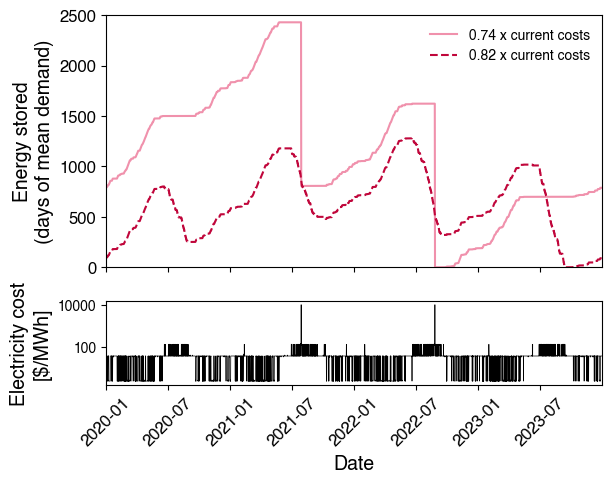

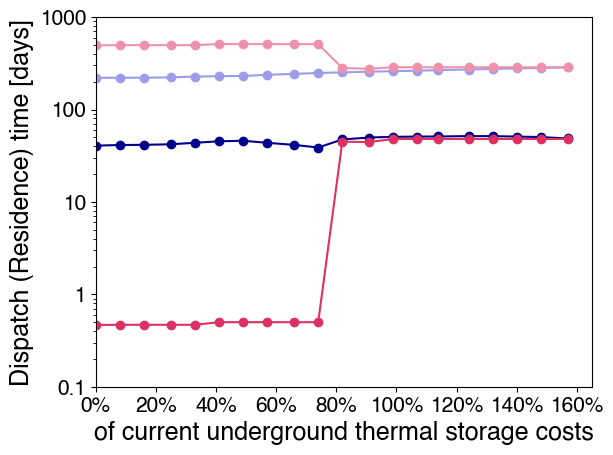

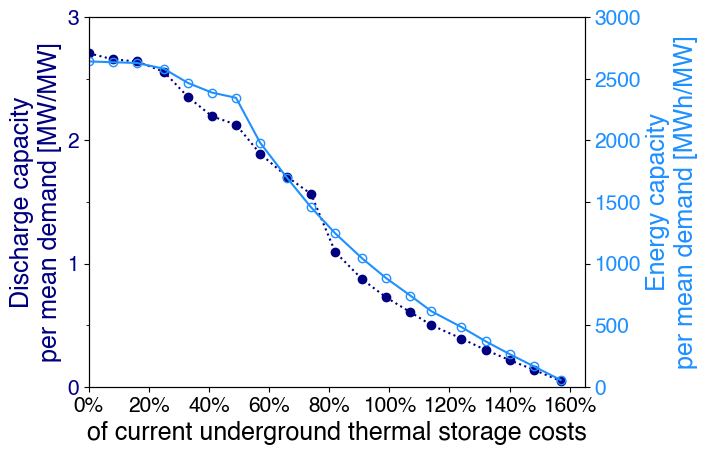

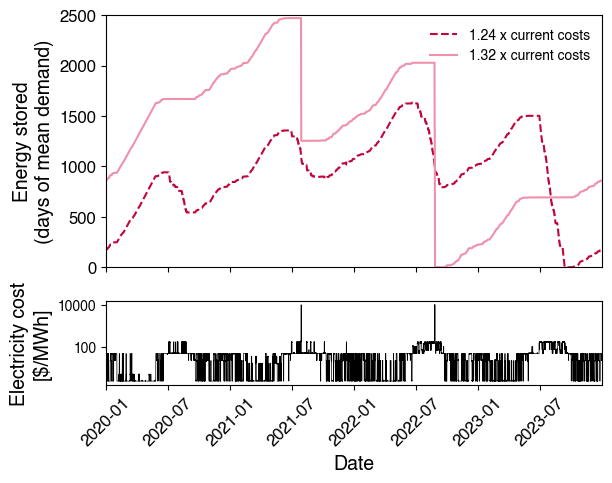

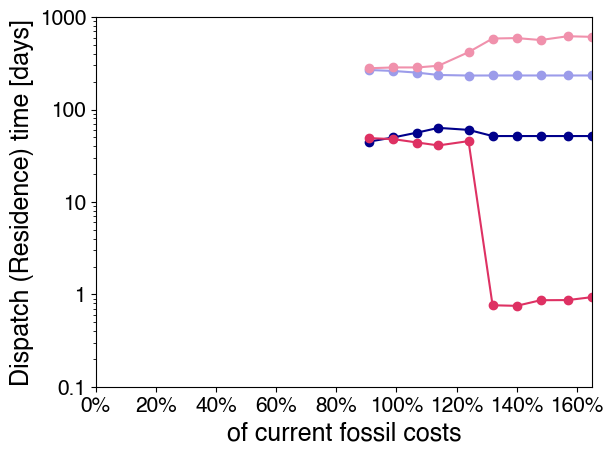

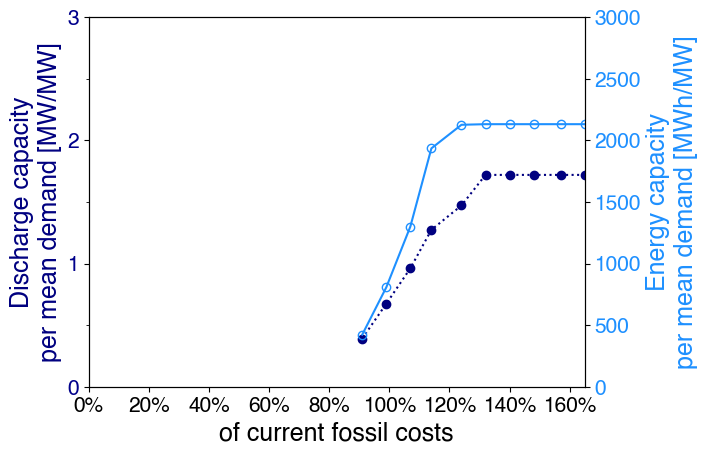

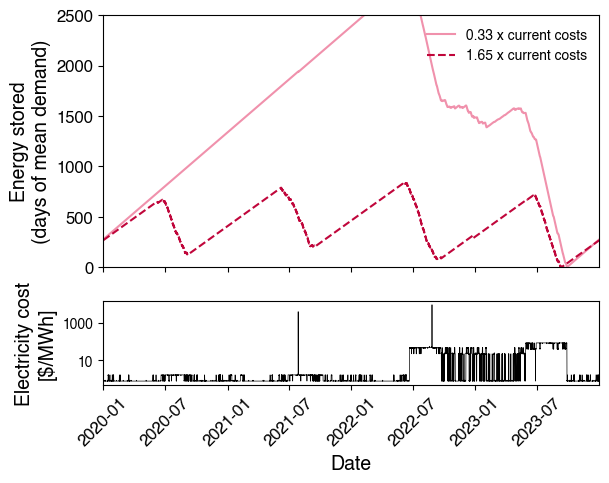

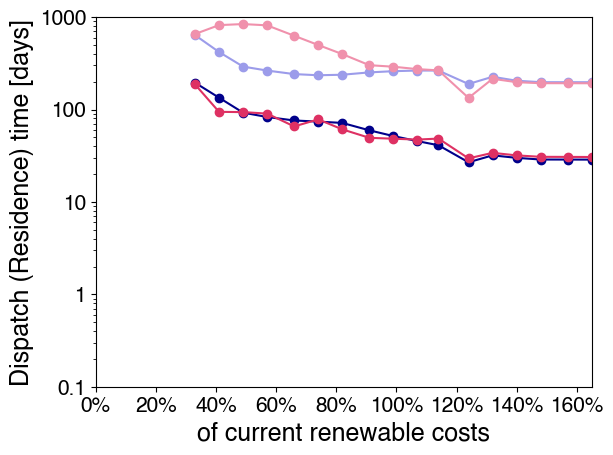

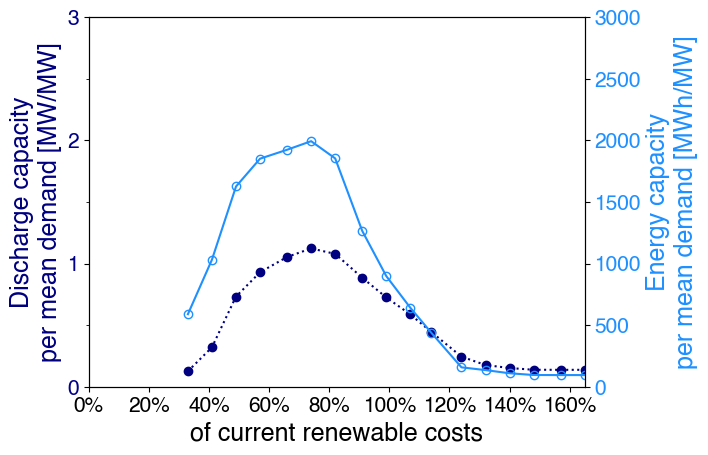

In [9]:
for case in ['BTES', 'fossil', 'renewable']:
    # Data paths
    data_path_taker = f'output_data/btes_base_case_orca_price_taker/btes_output_price_taker_base_{case}_costsx#COST.pickle'
    data_path_maker = f'output_data/btes_base_case_orca/btes_output_{case}_costsx#COST.pickle'
    rev_per_inv, discharge_time, mean_discharge_time, inv, capacity, capacity_store, energy_in_store, gen_capacity = collect_data(data_path_maker, data_path_taker, prices, case)

    # Replace p with . in prices
    prices_float = sorted([float(price.replace('p', '.')) for price in prices])

    # Plot discharge_time
    # Set values in price_taker to nan if they are nan in price_maker
    for i, val in enumerate(discharge_time['price_maker']):
        # investment
        if np.isnan(rev_per_inv['price_maker'][i]):
            rev_per_inv['price_taker'][i] = np.nan
        if np.isnan(val):
            discharge_time['price_taker'][i] = np.nan
        # Also in mean_discharge_time
        if np.isnan(mean_discharge_time['price_maker'][i]):
            mean_discharge_time['price_taker'][i] = np.nan

    # Plot dispatch and residence time
    plot_bars_maker_taker(case, prices_float, discharge_time, f'of current {case} costs', 
                      'Dispatch (Residence) time [days]', 'discharge_time',
                      y2=mean_discharge_time)
    # Plot energy and power capacity
    plot_capacity(prices_float, capacity, capacity_store, case)